Modeling a Moving Average Process

In [2]:
import pandas as pd

df = pd.read_csv(r"C:\Users\user\Downloads\widget_sales.csv")

df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


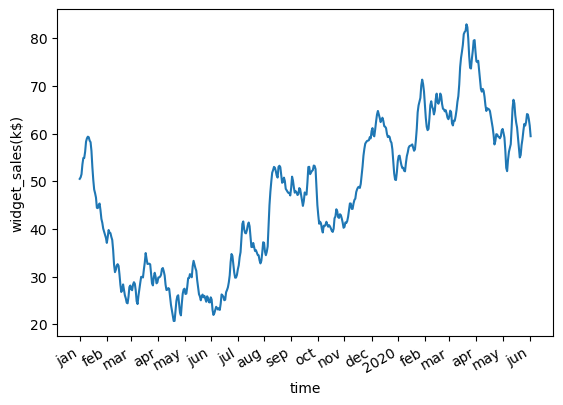

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('time')
ax.set_ylabel('widget_sales(k$)')

plt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','2020','feb','mar','apr','may','jun'])

fig.autofmt_xdate()
plt.show()


In [5]:
#test for stationarity

from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['widget_sales'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -1.5121662069359012
p-value: 0.5274845352272624


In [6]:
#time series is not stationary, thus apply transformation to make it stationary
#apply first order differencing
import numpy as np

widget_sales_diff = np.diff(df['widget_sales'], n=1) #n=1 is the order of differencing

In [7]:
#test for stationarity using ADF test

from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(widget_sales_diff)

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -10.576657780341952
p-value: 7.076922818587599e-19


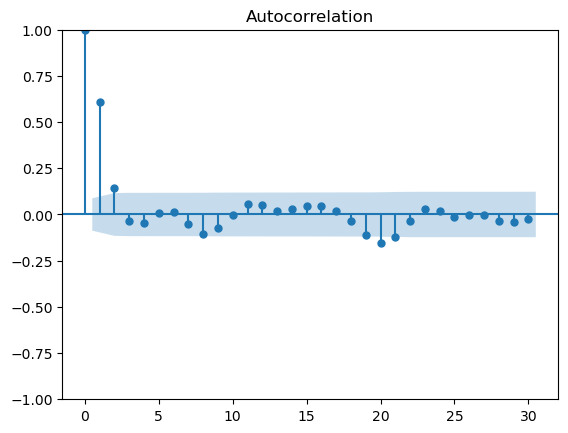

In [8]:
#plot the ACF function now that our series is stationary 
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(widget_sales_diff, lags=30)

plt.show()

Notice that there are significant coefficients up until lag 2. Then they abruptly become non-significant, as they remain in the shaded area of the plot. This means that we have a stationary moving average process of order 2. We can use a second-order moving average model, or MA(2) model, to forecast our stationary time series.

In [9]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff}) #place the differenced series in a dataframe

train = df_diff[:int(0.9*len(df_diff))] #split the data into train and test
test = df_diff[int(0.9*len(df_diff)):]

print(len(train), len(test))


449 50


Original dataset contained 500 data points, while the differenced series contains a total of 499 data points, since we differenced once.
Now we can visualize the forecasting period for the differenced and original series

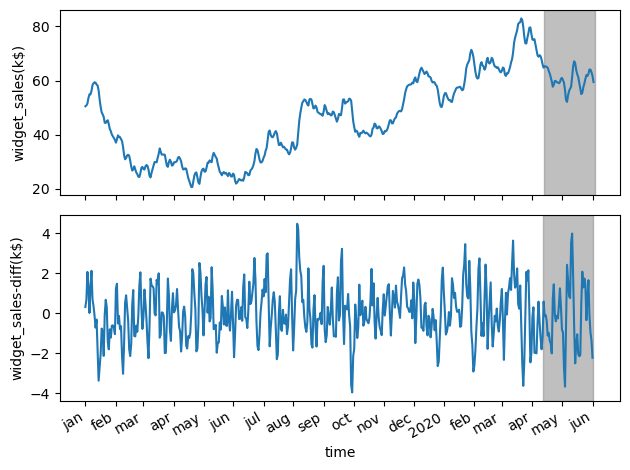

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('time')
ax1.set_ylabel('widget_sales(k$)')
ax1.axvspan(450,500,color='grey', alpha=0.5)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('time')
ax2.set_ylabel('widget_sales-diff(k$)')
ax2.axvspan(449,498,color='grey', alpha=0.5) #axvspan is used to add a vertical span

plt.xticks([0,30,57,87,116,145,175,204,234,264,293,323,352,382,409,439,468,498],
          ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec','2020','feb','mar','apr','may','jun'])

fig.autofmt_xdate()
plt.tight_layout()


Rolling Forecasts

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame,train_len:int, horizon:int, window:int, method: str) -> list:
    
    total_len = train_len + horizon

    if method =='mean':
        pred_mean= []

        for i in range(train_len, total_len, window):
            mean =np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range (window))

        return pred_mean
    elif method =='last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range (window))

        return pred_last_value
    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order = (0,0,2)) #the P,D,q,s parameters are set to zero except q=2
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA 

In [15]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean= rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['MA'] = pred_MA

pred_df.head()

,widget_sales_diff,mean,pred_last_value,MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


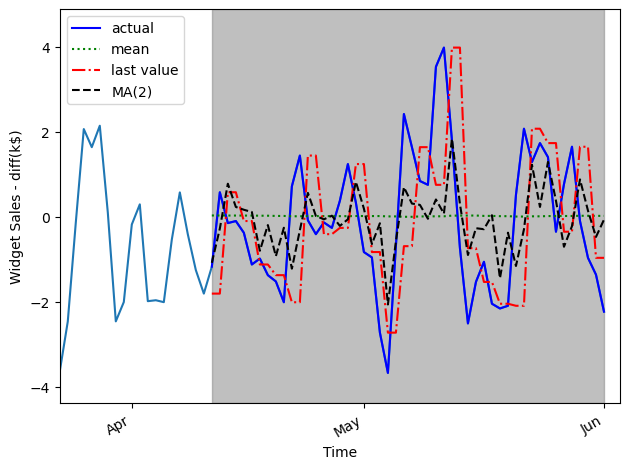

In [20]:
fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last value')
ax.plot(pred_df['MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget Sales - diff(k$)')

ax.axvspan(449,498,color='grey', alpha=0.5)

ax.set_xlim(430,500)

plt.xticks([439, 468, 498],
           ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.show()

Measure Performance of our models 

In [17]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['mean'])

mse_last = mean_squared_error(pred_df['widget_sales_diff'],pred_df['pred_last_value'])

mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['MA'])

print(f'mean: {mse_mean}')
print(f'last: {mse_last}')
print(f'MA: {mse_MA}')

mean: 2.5606299456880537
last: 3.2494260812249225
MA: 1.948171449756565


Our MA(2) model is the best performing since it has the lowest MSE recording

Let us inverse transform our predictions to return it to the original scale 

To obtain our predictions in the original scale of our dataset, we need to use the first value of the test as our initial value. Then we can perform a cumulative sum to obtain a series of 50 predictions in the original scale of the dataset. We will assign these predictions to the pred_widget_sales column.

In [22]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['MA'].cumsum()

C:\Users\user\AppData\Local\Temp\ipykernel_2860\627209539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['MA'].cumsum()


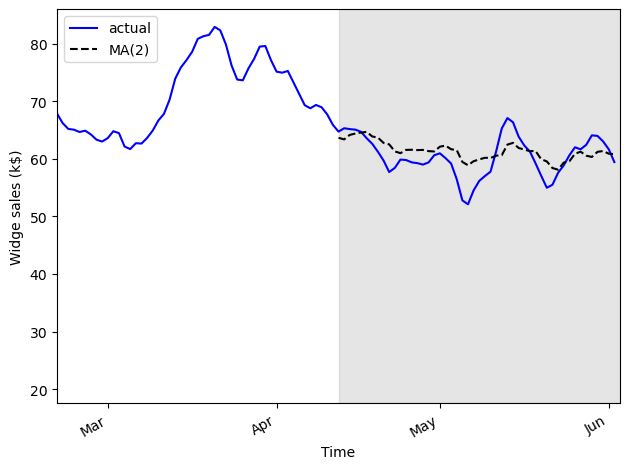

In [23]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-',label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widge sales (k$)')

ax.axvspan(450,500, color='grey', alpha=0.2)

ax.set_xlim(400,500)

plt.xticks([409, 439, 468,498],
           ['Mar','Apr','May','Jun'])

fig.autofmt_xdate()
plt.tight_layout()  

plt.show()

We can measure the mean absolute error (MAE) using the mean_absolute_error function from sklearn. We’ll use this metric because it is easy to interpret, as it returns the average of the absolute difference between the predicted and actual values,instead of a squared difference like the MSE

In [25]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
print(mae_MA_undiff)

2.324470924564214


Conclusion:

Our predictions are, on average, off by $2,320, either above or below the actual value. Remember that our data has units of thousands of dollars, so we multiply the MAE by 1,000 to express the average absolute difference.